In [14]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from ast import literal_eval
from sklearn.metrics import silhouette_score


pd.set_option('display.max_colwidth', 100)
csv_path = 'tmdb_5000_movies.csv'

if not os.path.exists(csv_path):
    print(f" Data not found: {csv_path}")
else:
    print(f" Data found: {csv_path}")

 Data found: tmdb_5000_movies.csv


In [15]:
df = pd.read_csv(csv_path)
df = df[['id', 'title', 'genres', 'overview', 'keywords', 'release_date', 'vote_average']].copy()

df['overview'] = df['overview'].fillna('')
df['genres'] = df['genres'].fillna('[]')
df['keywords'] = df['keywords'].fillna('[]')

def parse_features(x):
    try:
        data = literal_eval(x)
        if isinstance(data, list):
            return " ".join([i['name'] for i in data])
        return ""
    except:
        return ""

df['genres_str'] = df['genres'].apply(parse_features)
df['keywords_str'] = df['keywords'].apply(parse_features)

print("Load data:", df.shape)
df.head(2)

Load data: (4803, 9)


,id,title,genres,overview,keywords,release_date,vote_average,genres_str,keywords_str
0,19995,Avatar,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {...","In the 22nd century, a paraplegic Marine is dispatched to the moon Pandora on a unique mission, ...","[{""id"": 1463, ""name"": ""culture clash""}, {""id"": 2964, ""name"": ""future""}, {""id"": 3386, ""name"": ""sp...",2009-12-10,7.2,Action Adventure Fantasy Science Fiction,culture clash future space war space colony society space travel futuristic romance space alien ...
1,285,Pirates of the Caribbean: At World's End,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""name"": ""Action""}]","Captain Barbossa, long believed to be dead, has come back to life and is headed to the edge of t...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""name"": ""drug abuse""}, {""id"": 911, ""name"": ""exotic is...",2007-05-19,6.9,Adventure Fantasy Action,ocean drug abuse exotic island east india trading company love of one's life traitor shipwreck s...


In [16]:
# Feature Engineering für BoW (Bag of Words)
df['bow_features'] = df['keywords_str'] + " " + df['genres_str'] + " " + df['overview']

print("Training CountVectorizer...")
cv = CountVectorizer(max_features=5000, stop_words='english')
bow_matrix = cv.fit_transform(df['bow_features'])

print(" Old model is ready ")

Training CountVectorizer...
 Old model is ready 


In [17]:
print("Load SBERT Modell...")
model = SentenceTransformer('all-MiniLM-L6-v2')

# Feature Engineering für SBERT
df['semantic_features'] = df.apply(
    lambda row: f"Title: {row['title']}. Genre: {row['genres_str']}. Plot: {row['overview']}",
    axis=1
)

print("Calc Embeddings...")
# Wir berechnen das hier live, damit wir unabhängig von den .pkl Dateien sind
sbert_embeddings = model.encode(df['semantic_features'].tolist(), show_progress_bar=True)

print(" New model is ready ")

Load SBERT Modell...
Calc Embeddings...


Batches:   0%|          | 0/151 [00:00<?, ?it/s]

 New model is ready 


In [18]:
def compare_models(query, top_k=5):
    print(f"\n🔎 Search: '{query}'")
    print("="*80)

    # old model
    query_vec_bow = cv.transform([query])
    sim_bow = cosine_similarity(query_vec_bow, bow_matrix)[0]
    # sort
    top_indices_bow = sim_bow.argsort()[-top_k:][::-1]

    results_bow = []
    for idx in top_indices_bow:
        results_bow.append({
            "Title": df.iloc[idx]['title'],
            "Score": f"{sim_bow[idx]:.2f}",
            "Genre": df.iloc[idx]['genres_str']
        })

    # new model
    query_vec_sbert = model.encode([query])
    sim_sbert = cosine_similarity(query_vec_sbert, sbert_embeddings)[0]

    # sort
    top_indices_sbert = sim_sbert.argsort()[-top_k:][::-1]

    results_sbert = []
    for idx in top_indices_sbert:
        results_sbert.append({
            "Title": df.iloc[idx]['title'],
            "Score": f"{sim_sbert[idx]:.2f}",
            "Genre": df.iloc[idx]['genres_str']
        })

    # display
    df_bow = pd.DataFrame(results_bow)
    df_sbert = pd.DataFrame(results_sbert)

    print(" Bag-of-Words: ")
    display(df_bow)
    print("\n Semantic AI: ")
    display(df_sbert)

In [19]:
# Test 1: Exact Keywords (Both are good)
compare_models("Action movie with police and explosions")

# Test 2: Context Search (Old model fails often)
# "Traversing the universe" vs "Space Travel"
compare_models("A man traversing the universe to save humanity")

# Test 3: Emotion / Vibes (Speciality of SBERT)
# the word "disturbing" is rare in the genre, but SBERT knows the emotion
compare_models("A very disturbing psychological thriller about dreams")

# Test 4: Content Rewriting
# search "titanic" without using the word "titanic" or "ship""
compare_models("A romance that ends with a tragedy in the freezing atlantic ocean")


🔎 Search: 'Action movie with police and explosions'
 Bag-of-Words: 


,Title,Score,Genre
0,Disaster Movie,0.46,Action Comedy
1,Blue Streak,0.41,Action Comedy Crime
2,Last Action Hero,0.40,Adventure Fantasy Action Comedy Family
3,R.I.P.D.,0.37,Fantasy Action Comedy Crime
4,First Blood,0.36,Action Adventure Thriller War



 Semantic AI: 


,Title,Score,Genre
0,[REC]²,0.61,Thriller Horror
1,District B13,0.58,Action Thriller Science Fiction
2,In Too Deep,0.58,Drama Action Thriller Crime
3,Triple 9,0.57,Action Thriller
4,Extreme Ops,0.57,Action Adventure Drama Thriller



🔎 Search: 'A man traversing the universe to save humanity'
 Bag-of-Words: 


,Title,Score,Genre
0,Why I Did (Not) Eat My Father,0.30,Adventure Comedy Animation
1,Futuro Beach,0.30,Drama
2,A Serious Man,0.27,Comedy Drama
3,Super Mario Bros.,0.27,Adventure Comedy Family Fantasy
4,The Hit List,0.25,Action Thriller



 Semantic AI: 


,Title,Score,Genre
0,The Man from Earth,0.46,Science Fiction Drama
1,Timecrimes,0.41,Science Fiction Thriller
2,Jumper,0.41,Adventure Fantasy Science Fiction
3,The Hitchhiker's Guide to the Galaxy,0.41,Adventure Comedy Family Science Fiction
4,The Book of Eli,0.38,Action Thriller Science Fiction



🔎 Search: 'A very disturbing psychological thriller about dreams'
 Bag-of-Words: 


,Title,Score,Genre
0,Enter the Dangerous Mind,0.34,Thriller
1,The Gift,0.29,Thriller Mystery
2,In Dreams,0.27,Drama Thriller
3,A Nightmare on Elm Street 3: Dream Warriors,0.26,Horror Thriller
4,The Number 23,0.25,Thriller Drama Mystery



 Semantic AI: 


,Title,Score,Genre
0,Dream House,0.69,Drama Thriller Mystery
1,In Dreams,0.67,Drama Thriller
2,A Nightmare on Elm Street 3: Dream Warriors,0.66,Horror Thriller
3,A Nightmare on Elm Street 4: The Dream Master,0.64,Horror Thriller
4,Dreamcatcher,0.63,Drama Horror Science Fiction Thriller



🔎 Search: 'A romance that ends with a tragedy in the freezing atlantic ocean'
 Bag-of-Words: 


,Title,Score,Genre
0,Sphere,0.24,Science Fiction
1,Housefull,0.23,Drama Comedy Romance Foreign
2,Here On Earth,0.22,Romance
3,The Tourist,0.22,Action Thriller Romance
4,Warm Bodies,0.21,Horror Comedy Romance



 Semantic AI: 


,Title,Score,Genre
0,The Frozen,0.61,Horror Thriller
1,By the Sea,0.59,Drama Romance
2,The Deep End of the Ocean,0.59,Drama Mystery
3,Triangle,0.58,Horror
4,Swept Away,0.58,Comedy Romance


Calc t-SNE Projection (384D -> 2D)...


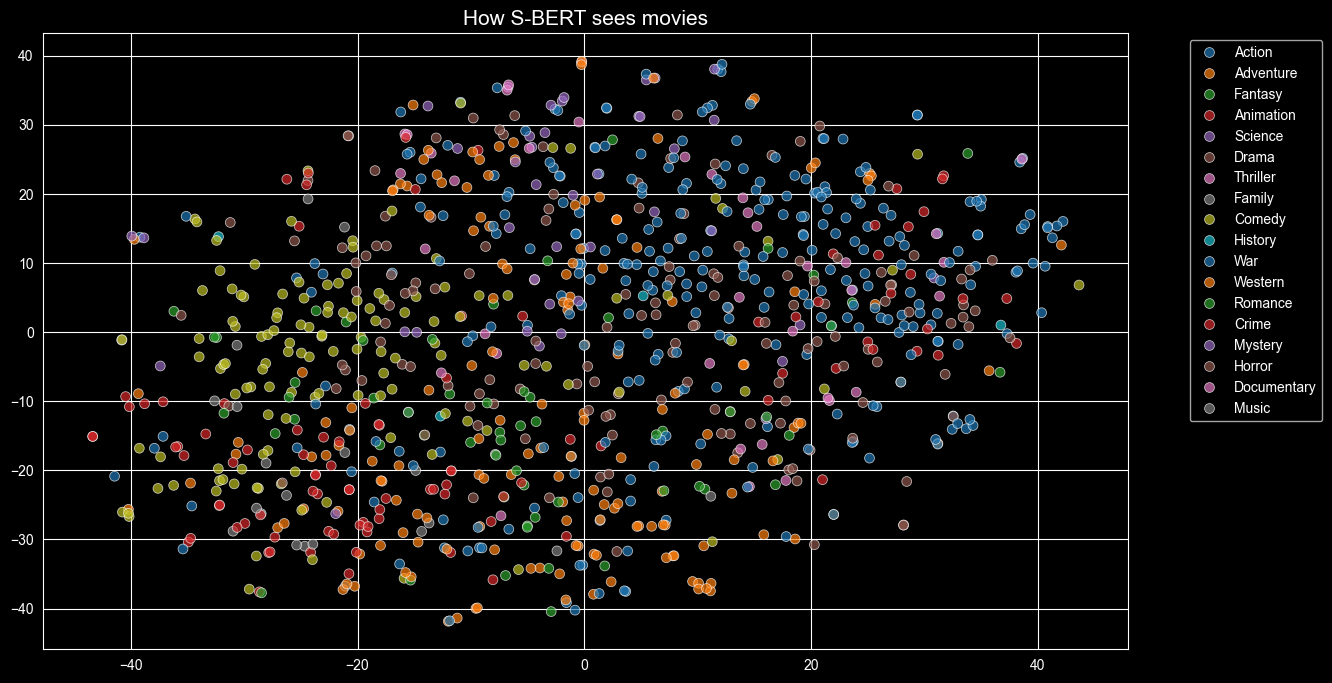

In [20]:
# only use 1000 movies for visualization
subset_limit = 1000
subset_embeddings = sbert_embeddings[:subset_limit]
subset_df = df.iloc[:subset_limit].copy()

# exctract main genre from genres_str
subset_df['main_genre'] = subset_df['genres_str'].apply(lambda x: x.split(" ")[0] if x else "Unknown")

print("Calc t-SNE Projection (384D -> 2D)...")
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
vis_dims = tsne.fit_transform(subset_embeddings)

x = [v[0] for v in vis_dims]
y = [v[1] for v in vis_dims]

plt.figure(figsize=(14, 8))
sns.scatterplot(x=x, y=y, hue=subset_df['main_genre'], palette="tab10", s=50, alpha=0.7)
plt.title("How S-BERT sees movies", fontsize=15)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)
plt.show()

 calc Clustering-Quality...
 BoW  Score:  -0.1741
 SBERT Score: -0.0318
 BoW Score:  -0.1741
 S-BERT Score: -0.0318
 Improvement: +81.7%
 Calc t-SNE (t-distributed Stochastic Neighbor Embedding) Projection (384D -> 2D) for both models


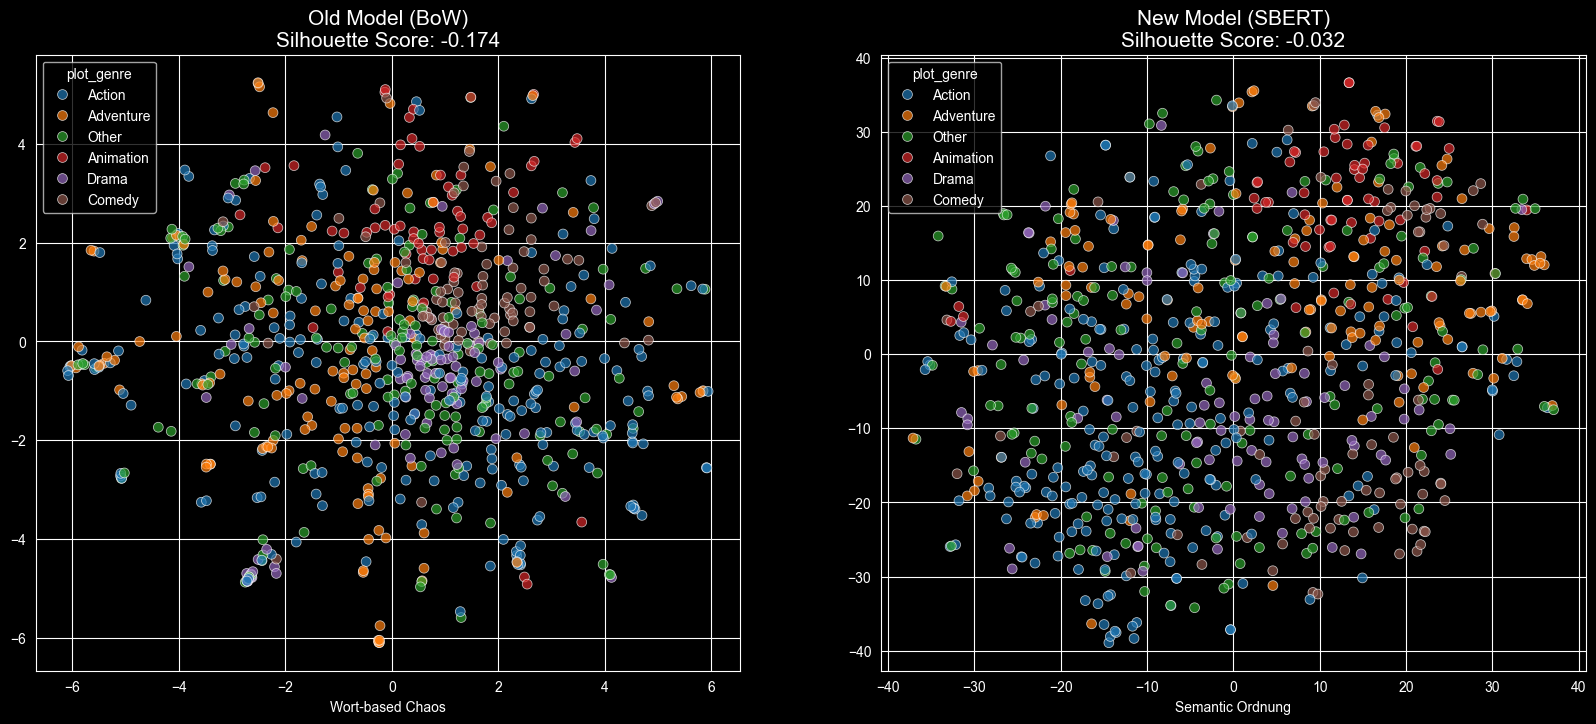

In [21]:
limit = 800
subset_df = df.iloc[:limit].copy()

subset_bow = cv.transform(subset_df['bow_features']).toarray()
subset_sbert = sbert_embeddings[:limit]

subset_df['main_genre'] = subset_df['genres_str'].apply(lambda x: x.split(" ")[0] if x else "Other")

# only top 5 genres
top_genres = subset_df['main_genre'].value_counts().head(5).index
subset_df['plot_genre'] = subset_df['main_genre'].apply(lambda x: x if x in top_genres else "Other")

print(" calc Clustering-Quality...")
score_bow = silhouette_score(subset_bow, subset_df['main_genre'])
score_sbert = silhouette_score(subset_sbert, subset_df['main_genre'])

print(f" BoW  Score:  {score_bow:.4f}")
print(f" SBERT Score: {score_sbert:.4f}")

improvement = ((score_sbert - score_bow) / abs(score_bow)) * 100
print(f" BoW Score:  {score_bow:.4f}")
print(f" S-BERT Score: {score_sbert:.4f}")
print(f" Improvement: +{improvement:.1f}%")

print(" Calc t-SNE (t-distributed Stochastic Neighbor Embedding) Projection (384D -> 2D) for both models")
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')

vis_bow = tsne.fit_transform(subset_bow)
vis_sbert = tsne.fit_transform(subset_sbert)

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Old Model
sns.scatterplot(
    x=vis_bow[:,0], y=vis_bow[:,1],
    hue=subset_df['plot_genre'],
    palette="tab10", s=50, alpha=0.7, ax=axes[0]
)
axes[0].set_title(f"Old Model (BoW)\nSilhouette Score: {score_bow:.3f}", fontsize=15)
axes[0].set_xlabel("Wort-based Chaos")

# Plot 2: New Model
sns.scatterplot(
    x=vis_sbert[:,0], y=vis_sbert[:,1],
    hue=subset_df['plot_genre'],
    palette="tab10", s=50, alpha=0.7, ax=axes[1]
)
axes[1].set_title(f"New Model (SBERT)\nSilhouette Score: {score_sbert:.3f}", fontsize=15)
axes[1].set_xlabel("Semantic Ordnung")

plt.show()

###  Similarity Distribution:

This density plot answers the question: *"If we pick two random movies from the **same genre** (e.g., Action A and Action B), how similar does the model think they are?"*

*   **Gray Curve (Old Model):** The peak is far to the left (near 0.0 - 0.1).
    *   The old model fails to recognize similarities. It thinks most movies of the same genre are completely different because they don't share the exact same vocabulary.
*   **Blue Curve (SBERT):** The peak is shifted to the right (around 0.3 - 0.6).
    SBERT recognizes the shared meaning. Even if the words differ, the "vibe" (vector direction) matches.

The shift to the right represents a massive gain in **Recall**. The new model is much more confident in identifying relevant connections between movies.
AN ideal model would have a peak close to 1.0, indicating it recognizes all movies of the same genre as highly similar.

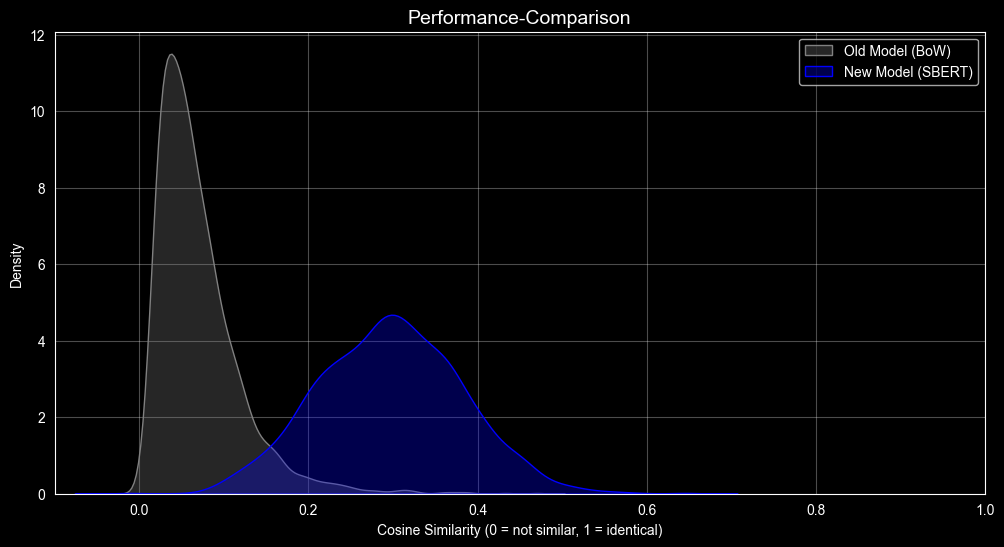

In [22]:
limit = 1000
sub_df = df.iloc[:limit].copy()
sub_sbert = sbert_embeddings[:limit]
sub_bow = cv.transform(sub_df['bow_features'])
sub_df['genre_main'] = sub_df['genres_str'].apply(lambda x: x.split(" ")[0] if x else "None")

def get_same_genre_similarities(matrix, labels, n_pairs=2000):
    sims = []
    indices = list(range(len(labels)))
    count = 0
    while count < n_pairs:
        i, j = random.sample(indices, 2)
        #  Genres are the same
        if labels.iloc[i] == labels.iloc[j] and labels.iloc[i] != "None":

            vec_i = matrix[i] if isinstance(matrix, np.ndarray) else matrix[i].toarray()
            vec_j = matrix[j] if isinstance(matrix, np.ndarray) else matrix[j].toarray()

            # shape check
            if vec_i.ndim == 1:
                vec_i = [vec_i]
            if vec_j.ndim == 1:
                vec_j = [vec_j]

            sim = cosine_similarity(vec_i, vec_j)[0][0]
            sims.append(sim)
            count += 1
    return sims

sims_bow = get_same_genre_similarities(sub_bow, sub_df['genre_main'])
sims_sbert = get_same_genre_similarities(sub_sbert, sub_df['genre_main'])


plt.figure(figsize=(12, 6))

# Density Plot (KDE)
sns.kdeplot(sims_bow, fill=True, label='Old Model (BoW)', color='gray', alpha=0.3)
sns.kdeplot(sims_sbert, fill=True, label='New Model (SBERT)', color='blue', alpha=0.3)

plt.title("Performance-Comparison", fontsize=14)
plt.xlabel("Cosine Similarity (0 = not similar, 1 = identical)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(-0.1, 1.0)

plt.show()